#### 무게를 찾기
- 목표 : 농어(Perch) 길이 피쳐를 사용해서 무게를 예측하기
- 데이터셋 : fish.csv
- 피쳐/속성 : Length
- 타겟/라벨 : Weight

[1] 데이터 준비 및 피쳐/타겟 분석

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

DATA_FILE = '../data/fish.csv'
fishDF=pd.read_csv(DATA_FILE, usecols=[0,1,2])

In [96]:
mask =fishDF.Species.isin(['Perch'])
fishDF1=fishDF[mask]
fishDF1.reset_index(drop=True, inplace=True)
fishDF1.index

RangeIndex(start=0, stop=56, step=1)

[1-1] 피쳐 분석 => 상관계수값, 시각화 2가지 모두 고려

[2] 학습 준비
- 학습알고리즘 : KNN Regressor
- 피쳐스케일링
- 학습용/테스트용 데이터셋 분리

[2-1] 피쳐와 타겟 분리

In [97]:
features=fishDF1[['Length']]
target=fishDF1['Weight']

print(f'features => {features.shape}, {features.ndim}D')
print(f'target=> {target.shape}, {target.ndim}D')

features => (56, 1), 2D
target=> (56,), 1D


[2-2] 학습용 & 테스트용 데이터셋 분리
- 전체 데이터셋 => 학습용:테스트용=75:25, 80:20, 70:30

In [98]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target,
                                                    random_state=10) # 최적의 k 찾기전 까지는 풀면 안됨

In [99]:
print(f'X_train : {X_train.shape}, {X_train.ndim}D') 
print(f'y_train : {y_train.shape}, {y_train.ndim}D')

print(f'X_test  : {X_test.shape}, {X_test.ndim}D') 
print(f'y_test  : {y_test.shape}, {y_test.ndim}D')

X_train : (42, 1), 2D
y_train : (42,), 1D
X_test  : (14, 1), 2D
y_test  : (14,), 1D


In [100]:
X_train=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)

X_test=X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

[2-3] 피쳐 스케일링

In [101]:
mmScaler = MinMaxScaler()

In [102]:
mmScaler.fit(X_train)

MinMaxScaler()

In [103]:
mmScaler.min_, mmScaler.scale_

(array([-0.23595506]), array([0.02808989]))

In [104]:
# 학습용/테스트용 데이터셋 스케일링 진행
X_train_scaled=mmScaler.transform(X_train)
X_test_scaled=mmScaler.transform(X_test)

In [105]:
X_test_scaled = mmScaler.transform(X_test)
X_test_scaled.shape, X_test_scaled.min(), X_test_scaled.max()

((14, 1), 0.18539325842696627, 0.8595505617977527)

[3] 학습 진행

In [106]:
from sklearn.neighbors import KNeighborsRegressor

# 학습 모델 인스턴스 생성
model = KNeighborsRegressor()

# 학습용 데이터셋으로 학습 진행
model.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [107]:
# 모델 파라미터 => 학습 후 즉, fit() 실행 후 설정되는 매개변수
model.n_features_in_, model.n_samples_fit_, model.effective_metric_, model.effective_metric_params_

(1, 42, 'euclidean', {})

[4] 최적의 K 찾기

In [108]:
scores={}
for k in range(1, model.n_samples_fit_+1):
    # 최근접 이웃의 개수 설정 <= 모델 성능 좌우 : 하이퍼파라미터
    model.n_neighbors=k

    # 성능 평가
    score=model.score(X_test_scaled, y_test)

    scores[k]=score

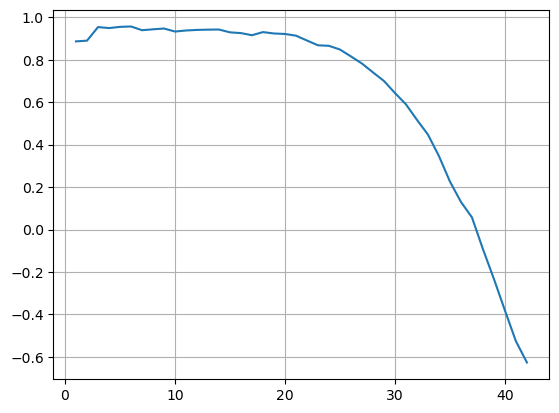

In [109]:
plt.plot(list(scores.keys()), list(scores.values()))
plt.grid()
plt.show()

In [110]:
# 최고 성능의 K값                         x=(key, value)
best_k=sorted(scores.items(), key=lambda x:x[1], reverse=True)[0][0]
best_k

6

In [111]:
# 모델에 적용 => n_neighbors에 설정
model.n_neighbors=best_k

[5] 새로운 데이터의 무게 예측하기

In [112]:
new_length=input('농어 길이 : ')
print(f'new_length : {new_length}')

new_length : 44


In [113]:
# 2D DataFrame
dataDF=pd.DataFrame([[new_length]],columns=['Length'])
dataDF

,Length
0,44


In [114]:
# 피쳐 스케일링
data_scaled=mmScaler.transform(dataDF)

In [115]:
# 예측
model.predict(data_scaled)

array([1008.33333333])

In [116]:
distance, index=model.kneighbors(data_scaled)

print(distance, index, sep='\n')

[[0.         0.01404494 0.02808989 0.02808989 0.05617978 0.11235955]]
[[31 27 30  3 15 12]]


In [117]:
X_train.iloc[index.reshape(-1)]

,Length
31,44.0
27,43.5
30,43.0
3,43.0
15,42.0
12,40.0


In [118]:
X_train_scaled[[31,27,30,3,15,12]]

array([[1.        ],
       [0.98595506],
       [0.97191011],
       [0.97191011],
       [0.94382022],
       [0.88764045]])

In [119]:
y_train[index.reshape(-1)].sum()/model.n_neighbors

1008.3333333333334

In [120]:
y_train[[31,27,30,3,15,12]]

31    1000.0
27    1000.0
30    1000.0
3     1100.0
15    1100.0
12     850.0
Name: Weight, dtype: float64

#### KNN Regressor 문제점/단점

In [121]:
# 임의의 데이터
new_length = 8

# 2D DataFrame
dataDF=pd.DataFrame([[new_length]],columns=['Length'])

# 피쳐스케일링
data_scaled=mmScaler.transform(dataDF)

In [122]:
# 예측
model.predict(data_scaled)

array([60.98333333])

=> 학습 데이터셋의 범위를 벗어난 더 큰 데이터, 더 작은 데이터의 경우  
정확한 예측이 불가능